# Introduction
We will attempt to use convonlutional neural network on the dataset. This is the initial attempt so we will apply it on a very small dataset on the raw data in one channel (vertical). First, let us import the required packages including tensorflow.

In [1]:
#import tensorflow as tf;
import matplotlib.pyplot as plt
import numpy as np

from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy import UTCDateTime
from obspy.clients.fdsn import Client



import pickle

Let us define a retrieval function to be used for getting the data

In [168]:
def getEvents(clientName, networkName,  stationName, startTime, endTime, minMagnitude, maxRadius):
    '''
    Get the events
    '''
    # Find the possible earthquakes and put them in a catalog
    client = Client(clientName)
    inventory = client.get_stations(network=networkName, station=stationName)
    station = inventory[0][0]
    cat = client.get_events(starttime=startTime, endtime=endTime, minmagnitude=minMagnitude, latitude=station.latitude, longitude=station.longitude, maxradius=maxRadius)
    
    return cat

def getStreams(clientName, networkName,  stationName, cat, timeBefore, timeAfter):
    '''
    Get the streams for the events
    '''
    client = Client(clientName)
    inventory = client.get_stations(network=networkName, station=stationName)
    station = inventory[0][0]
    
    # Get the stream for each event
    model = TauPyModel(model="iasp91")
    
    nEvents = len(cat)
    print("Will analyze " + str(nEvents) + " events")
    stList = []
    for i in range(0, nEvents):
        try:
            print("Analyzing event " + str(i))
            event = cat[i]
            origin = event.origins[0]
            distance, _, _ = gps2dist_azimuth(origin.latitude, origin.longitude, station.latitude, station.longitude)
            distance = kilometer2degrees(distance / 1e3)
            arrivals = model.get_travel_times(origin.depth / 1e3, distance)
            traveltime = arrivals[0].time
            arrival_time = origin.time + traveltime

            # Get the earthquake signal and store its needed information
            st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-timeBefore, endtime=arrival_time+timeAfter)
            stList.append(st)
        except:
            print("Could not get stream " + str(i))
    return stList

def getRandomStreams(clientName, networkName,  stationName, timeBefore, timeAfter, starttime=startTime, endtime=endTime, nEvents = 1):
    '''
    Get the streams for the events
    '''
    client = Client(clientName)

    
    print("Will analyze " + str(nEvents) + " events")
    stList = []
    for i in range(0, nEvents):
        try:
            print("Analyzing event " + str(i))
            arrival_time = startTime + (endTime - startTime) * np.random.random()
            st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-timeBefore, endtime=arrival_time+timeAfter)
            stList.append(st)
        except:
            i = i-1
            print("Could not get stream " + str(i))
    return stList

let us make a function that save and load the list of seismogram. It is a list of objects so we have to use the package pickle which is included in python by default.

In [3]:
def saveList(listToSave, fileName = 'SavedList.dat'):
    '''
    Save a list into a file.
    '''
    pickle.dump( listToSave, open(fileName, "wb" ))


def loadList(fileName):
    '''
    Load a list from a file
    '''
    loadedList = pickle.load( open( fileName, "rb" ))
    return loadedList

Finally, we define a function to extract the data to numpy format for further analysis.

In [152]:
def st2numpy(st):
    '''
    Retrive import information from the seismogram
    '''
    trace = st.pop()
    data = trace.data
    time = trace.times('matplotlib')
    return time, data

def stList2numpy(stList , label=1):
    nSt = len(stList)
    timeList = []
    dataList = []
    labelList = []
    
    for i in range(0, nSt):
        time, data = st2numpy(stList[i])
        timeList.append(time)
        dataList.append(data)
        labelList.append(label)
    
    timeArray = np.asarray(timeList).T;
    dataArray = np.asarray(dataList).T;
    labelArray = np.asarray(labelList).T;
    labelArray = labelArray[:,np.newaxis]

    return timeArray, dataArray, labelArray
  

# Building the dataset
Now, let us retrieve the dataset and save it.

In [183]:
networkName      = "BK"
stationName      = "PKD"
clientName       = "NCEDC"
startTime        = UTCDateTime("2010-01-01")
endTime          = UTCDateTime("2018-05-13")
maxRadius        = .5 # angle
minMagnitude     = 2
channelName      = "LHZ" #vertical

timeAfter  = -60;      # seconds
timeBefore = 60+1024; # seconds
pos2neg = 1;

cat  = getEvents(clientName, networkName,  stationName, startTime, endTime, minMagnitude, maxRadius)
len(cat)

741

In [184]:
stListPositives = getStreams(clientName, networkName,  stationName, cat, timeBefore, timeAfter)

nNegatives = int(pos2neg * len(stListPositives))
stListNegatives = getRandomStreams(clientName, networkName,  stationName, timeBefore, timeAfter, startTime, endTime, nNegatives)

saveList(stListPositives, fileName = 'PositivesList2.dat')
saveList(stListNegatives, fileName = 'NegativesList2.dat')

Will analyze 741 events
Analyzing event 0
Analyzing event 1
Analyzing event 2
Analyzing event 3
Analyzing event 4
Analyzing event 5
Analyzing event 6
Analyzing event 7
Analyzing event 8
Analyzing event 9
Analyzing event 10
Analyzing event 11
Analyzing event 12
Analyzing event 13
Analyzing event 14
Analyzing event 15
Analyzing event 16
Analyzing event 17
Analyzing event 18
Analyzing event 19
Analyzing event 20
Analyzing event 21
Analyzing event 22
Analyzing event 23
Analyzing event 24
Analyzing event 25
Analyzing event 26
Analyzing event 27
Analyzing event 28
Analyzing event 29
Analyzing event 30
Analyzing event 31
Analyzing event 32
Analyzing event 33
Analyzing event 34
Analyzing event 35
Analyzing event 36
Analyzing event 37
Analyzing event 38
Analyzing event 39
Analyzing event 40
Analyzing event 41
Analyzing event 42
Analyzing event 43
Analyzing event 44
Analyzing event 45
Analyzing event 46
Analyzing event 47
Analyzing event 48
Analyzing event 49
Analyzing event 50
Analyzing event 5

In [185]:
timeArrayNeg, dataArrayNeg, labelArrayNeg = stList2numpy(stListNegatives, label = 0)
timeArrayPos, dataArrayPos, labelArrayPos = stList2numpy(stListPositives, label = 1)

In [198]:
time  = np.concatenate([timeArrayPos , timeArrayNeg], axis = 1);
data  = np.concatenate([dataArrayPos , dataArrayNeg], axis = 1);
label = np.concatenate([labelArrayPos , labelArrayNeg]);
np.save("time.npy", time)
np.save("data.npy", data)
np.save("label.npy", label)

In [199]:
label.shape

(1366, 1)

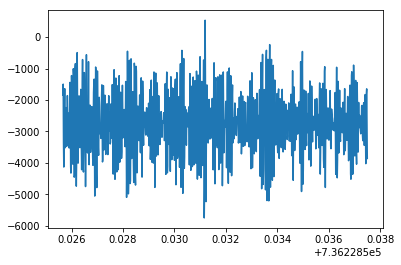

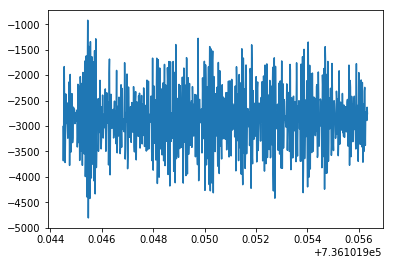

In [172]:
i = 1
fig = plt.figure()
plt.plot(timeArrayNeg[:,i], dataArrayNeg[:,i])
fig = plt.figure()
plt.plot(timeArrayPos[:,i], dataArrayPos[:,i])